## Thompson sampling and the Binary Bernoulli Bandit Problem
This example will familiarize students with variants of [Thompson Sampling](https://arxiv.org/abs/1707.02038) for the solution of Binary Bernoulli Bandit Problems (BBBPs) which is a special [Multi-arm Bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit) where the agent receives a reward of $r\in\left\{0,1\right\}$ which is governed by a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)

## Setup
This example requires several external libraries and a function to compute the outer product. Let's download and install these packages and call our `Include.jl` file.

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-15/L15a`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-15/L15a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-15/L15a/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-15/L15a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-15/L15a/Manifest.toml`


## Setup the world

In [2]:
# initialize the world -
world_d_dict = Dict{Int64, Bernoulli}();
K = 3;
θ_array = [0.90, 0.60, 0.80]; # values taken from Russo et al Fig. 3.1
number_of_steps = 5000;
    
# hard code the parameters for the Bernoulli distributions, these are the 
# ground truth, but the agent doesn't know them (and they are directly visible)
for k ∈ 1:K
    world_d_dict[k] = Bernoulli(θ_array[k]);
end

The `world` function encodes the response the agent receives from taking action $a\in\mathcal{A}$. In `BBBPs`, this reward is binary $r\in\left\{0,1\right\}$ and governed by a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution).
* The `world` function takes in the action $a\in\mathcal{A}$ chosen by the agent, and the `world_d_dict` dictionary and return a reward value `r`

In [3]:
# Let's build a world function -
function world(action::Int64, dict::Dict{Int64, Bernoulli})::Int64

    # initialize -
    reward = nothing
    
    # grab the distribution from the dict -
    d = dict[action];
    
    value = rand(d);
    value == true ? reward = 1 : reward = 0;

    # return -
    return reward;
end;

## Thompson Sampling
In Thompson sampling, the agent chooses the greedy action, i.e., the action $a\in\mathcal{A}$ that, up to now, has given the best return. We model this approach using the `ThompsonSamplingModel` type encoded in the [Types.jl](src/Types.jl). We store this sampling model in the `model` variable.

In [4]:
# build Thompson sample object -
model = ThompsonSamplingModel()
model.K = K;
model.α = ones(K); # initialize to uniform values
model.β = ones(K); # initialize to uniform values

To sample the world, we pass the sampling model instance, i.e., the `model` variable, a `world` function, and the number of steps (the `horizon` of the game) to the `sample` function encoded in the [Bandits.jl file](src/Bandits.jl). 
* The `sample` function returns a dictionary of time sample results; we store these results in the `time_sample_results_dict_Ts` variable. The keys of the dictionary are the indexes of the game rounds, while the values are the $\alpha,\beta$ values for the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)

In [5]:
# build the world function, and sample it 
world_function(a) = world(a, world_d_dict);
time_sample_results_dict_Ts = sample(model; 𝒯 = number_of_steps, world=world_function)

Dict{Int64, Matrix{Float64}} with 5000 entries:
  4986 => [4432.0 480.0; 2.0 4.0; 59.0 14.0]
  4700 => [4177.0 451.0; 2.0 4.0; 57.0 14.0]
  4576 => [4066.0 440.0; 2.0 4.0; 55.0 14.0]
  2288 => [2023.0 218.0; 1.0 4.0; 37.0 10.0]
  1703 => [1510.0 151.0; 1.0 4.0; 32.0 10.0]
  1956 => [1731.0 183.0; 1.0 4.0; 32.0 10.0]
  2350 => [2081.0 222.0; 1.0 4.0; 37.0 10.0]
  3406 => [3017.0 327.0; 1.0 4.0; 49.0 13.0]
  2841 => [2514.0 276.0; 1.0 4.0; 41.0 10.0]
  2876 => [2547.0 278.0; 1.0 4.0; 41.0 10.0]
  687  => [593.0 53.0; 1.0 4.0; 31.0 10.0]
  185  => [131.0 15.0; 1.0 4.0; 29.0 10.0]
  1090 => [964.0 85.0; 1.0 4.0; 31.0 10.0]
  2015 => [1782.0 191.0; 1.0 4.0; 32.0 10.0]
  3293 => [2918.0 316.0; 1.0 4.0; 46.0 13.0]
  1704 => [1511.0 151.0; 1.0 4.0; 32.0 10.0]
  3220 => [2850.0 311.0; 1.0 4.0; 46.0 13.0]
  4888 => [4342.0 473.0; 2.0 4.0; 58.0 14.0]
  422  => [349.0 32.0; 1.0 4.0; 31.0 10.0]
  1266 => [1122.0 103.0; 1.0 4.0; 31.0 10.0]
  183  => [129.0 15.0; 1.0 4.0; 29.0 10.0]
  1823 => [1615.0

In [6]:
time_sample_results_dict_Ts[5000]

3×2 Matrix{Float64}:
 4446.0  480.0
    2.0    4.0
   59.0   14.0

## $\epsilon$-Greedy Thompson Sampling
Unlike Thompson sampling, $\epsilon$-Greedy Thompson Sampling sometimes chooses random actions along with the best action identified so far. When agents choose a random action, they are `exploring` the world. On the other hand, when selecting the best action so far, they are `exploiting` their knowledge of the world gained through experience 
* We build an instance of `EpsilonSamplingModel,` which is similar to `ThompsonSamplingModel` type __except__ now we have an `ϵ` parameter which specifies the fraction of random actions the agent chooses. We save the `EpsilonSamplingModel` instance in the `epsilon_model` variable

In [7]:
# Build an epsilon sample object -
epsilon_model = EpsilonSamplingModel();
epsilon_model.K = K;
epsilon_model.α = ones(K); # initialize to uniform values
epsilon_model.β = ones(K); # initialize to uniform values
epsilon_model.ϵ = 0.20; # some fraction of the iterations, do a random step

To sample the world, we pass the sampling model instance, i.e., the `epsilon_model` variable, a `world` function, and the number of steps (the `horizon` of the game) to the `sample` function encoded in the [Bandits.jl file](src/Bandits.jl). 
* The `sample` function returns a dictionary of time sample results; we store these results in the `time_sample_results_dict_eps` variable. The keys of the dictionary are the indexes of the game rounds, while the values are the $\alpha,\beta$ values for the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)

In [8]:
time_sample_results_dict_eps = sample(epsilon_model; 𝒯 = number_of_steps, world=world_function);

In [9]:
time_sample_results_dict_eps[5000]

3×2 Matrix{Float64}:
 3901.0  425.0
  188.0  137.0
  287.0   67.0

## Visualize
Let's build a table that shows the actual value of the reward probability $\theta$, along with the expected values obtained from Thompson sampling or $\epsilon$-Greedy Thompson sampling. Later, we'll plot the [Beta distributions](https://en.wikipedia.org/wiki/Beta_distribution) associated with each action. However, specify an index to look at in the `T_index` variable first:

In [10]:
T_index = 5000; # pick a time step to explore

`Unhide` the code block below to see how we use the [PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl) to display the true and expected parameter values

In [11]:
# build the array of beta distributions -
beta_array_Ts = build_beta_array(time_sample_results_dict_Ts[T_index]);
beta_array_eps = build_beta_array(time_sample_results_dict_eps[T_index]);

# initialize -
action_probability_array = Array{Any,2}(undef, K, 4);
for i ∈ 1:K
    
    action_probability_array[i,1] = i;
    action_probability_array[i,2] = θ_array[i];
    
    # get the d -
    d_Ts = beta_array_Ts[i];
    d_eps = beta_array_eps[i];
    
    # grab the parameters from distributions -
    # Thompson sampling -
    αᵢ,βᵢ = params(d_Ts);
    action_probability_array[i,3] = αᵢ/(αᵢ + βᵢ);
    
    # eps-TS -
    αᵢ,βᵢ = params(d_eps);
    action_probability_array[i,4] = αᵢ/(αᵢ + βᵢ);
end

# header -
action_table_header = (["Action aᵢ", "θᵢ", "θ̂ᵢ Ts", "θ̂ᵢ eps-Ts"]);

# display table -
pretty_table(action_probability_array; header = action_table_header)

┌───────────┬─────┬──────────┬───────────┐
│ Action aᵢ │  θᵢ │    θ̂ᵢ Ts │ θ̂ᵢ eps-Ts │
├───────────┼─────┼──────────┼───────────┤
│         1 │ 0.9 │ 0.902558 │  0.901757 │
│         2 │ 0.6 │ 0.333333 │  0.578462 │
│         3 │ 0.8 │ 0.808219 │  0.810734 │
└───────────┴─────┴──────────┴───────────┘


`Unhide` the code block below to see how we plot the [Beta distributions](https://en.wikipedia.org/wiki/Beta_distribution) for each action $a\in\mathcal{A}$ obtained from Thompson sampling after `T` game rounds:

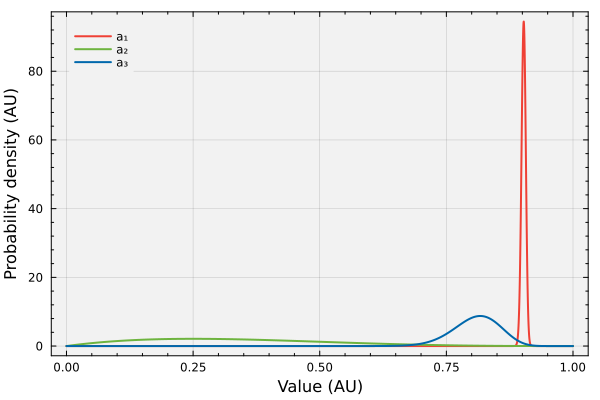

In [12]:
# get the distributions for this time point -
plot(beta_array_Ts[1], legend=:topleft, label="a₁", lw=2, bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, minorticks=0.05, 
    c=colorant"#EF4035")
plot!(beta_array_Ts[2], label="a₂", lw=2, c=colorant"#6EB43F")
plot!(beta_array_Ts[3], label="a₃", lw=2, c=colorant"#0068AC")

# setup labels -
xlabel!("Value (AU)", fontsize=18)
ylabel!("Probability density (AU)", fontsize=18)

`Unhide` the code block below to see how we plot the [Beta distributions](https://en.wikipedia.org/wiki/Beta_distribution) for each action $a\in\mathcal{A}$ obtained from $\epsilon$-Greedy Thompson sampling after `T` game rounds:

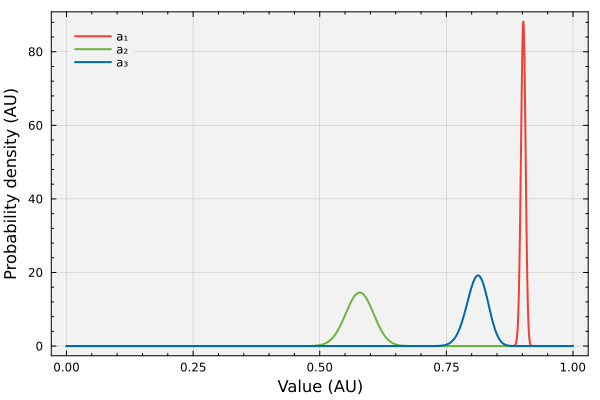

In [13]:
 # get the distributions for this time point -
plot(beta_array_eps[1], legend=:topleft, label="a₁", lw=2, bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, minorticks=0.05, 
    c=colorant"#EF4035")
plot!(beta_array_eps[2], label="a₂", lw=2, c=colorant"#6EB43F")
plot!(beta_array_eps[3], label="a₃", lw=2, c=colorant"#0068AC")

# setup labels -
xlabel!("Value (AU)", fontsize=18)
ylabel!("Probability density (AU)", fontsize=18)